<a href="https://colab.research.google.com/github/CNielsen94/Random_data_repo/blob/main/Scrape_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to (almost ethically) scrape some actual data

Web scraping is a very efficient way of getting real-life data, however it is also very much a grey area in terms of legality and ethics. Some websites don't allow any type of bot activity on their domain, which you should respect. This is typically denoted in their robots.txt, which usually is a subdomain that can be looked up.

If you end up scraping, it is also important to be respectful of rate limiting! You do not want to stress their servers, so whilst you could theoretically send 1000 requests off at once and scrape in minutes, it's somewhat equivelant of performing a DDoS(Denial of Service)-attack which could make their online services run slow.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ===========================================
# BoligPortal Aalborg Scraper
# ===========================================

# 1. Update package lists
!apt-get update -qq

# 2. Install dependencies for adding repositories
!apt-get install -y wget apt-transport-https -qq

# 3. Download the Google Chrome GPG key and add it to the system keyring
# NOTE: Using 'apt-key add' is deprecated, but common in Colab setup scripts.
!wget -q https://dl.google.com/linux/linux_signing_key.pub -O- | sudo apt-key add -

# 4. Add the Google Chrome repository to the sources list
!echo "deb [arch=amd64] https://dl.google.com/linux/chrome/deb/ stable main" | sudo tee /etc/apt/sources.list.d/google-chrome.list

# 5. Update package lists again (now with the new repository)
!apt-get update -qq

# 6. Install the stable Google Chrome
!apt-get install -y google-chrome-stable -qq

# Install necessary Python libraries
!pip install selenium webdriver-manager python-dateutil tqdm -q

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package apt-transport-https.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../apt-transport-https_2.4.14_all.deb ...
Unpacking apt-transport-https (2.4.14) ...
Setting up apt-transport-https (2.4.14) ...
OK
deb [arch=amd64] https://dl.google.com/linux/chrome/deb/ stable main
W: https://dl.google.com/linux/chrome/deb/dists/stable/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libvulkan1:amd64.
(Reading database .

In [ ]:
import selenium
import time
import re
import json
from urllib.parse import urljoin
from datetime import datetime
from tqdm import tqdm

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException

# Use this to automatically manage chromedriver version
from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
def make_driver():
    """Initializes and returns the Selenium WebDriver using Chrome Stable."""
    chrome_options = Options()
    # Binary location remains correct for the newly installed package
    chrome_options.binary_location = "/usr/bin/google-chrome"

    # Standard headless arguments
    chrome_options.add_argument("--headless=new")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument("--start-maximized")

    # Use ChromeDriverManager to automatically download the correct driver
    service = Service(ChromeDriverManager().install())

    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# -------------------------
# DRIVER INITIALIZATION
# -------------------------
try:
    driver = make_driver()
    print("WebDriver initialized successfully.")
except WebDriverException as e:
    print(f"FATAL ERROR: Could not initialize WebDriver.")
    print(e)
    # Raising the error to stop execution
    raise

# -------------------------
# CONFIG
# -------------------------
BASE_SEARCH = "https://www.boligportal.dk/lejligheder/aalborg/"
PAGE_SIZE = 18
TOTAL_PAGES = 74
DELAY_SEARCH = 2
DELAY_DETAIL = 1.5
MAX_RETRIES = 3
OUTPUT_FILE = "boligportal_aalborg.jsonl"

# -------------------------
# UTILS
# -------------------------
def collect_urls():
    urls = set()
    print("\n--- Starting URL Collection ---")
    for p in tqdm(range(TOTAL_PAGES), desc="Collecting URLs"):
        offset = p * PAGE_SIZE
        url = BASE_SEARCH if offset == 0 else f"{BASE_SEARCH}?offset={offset}"

        for r in range(MAX_RETRIES):
            try:
                driver.get(url)
                WebDriverWait(driver, 20).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'a[href^="/lejligheder/aalborg/"]'))
                )
                break
            except TimeoutException:
                print(f"Timeout on page {p}, attempt {r+1}/{MAX_RETRIES}. Retrying...")
                if r == MAX_RETRIES - 1:
                    print(f"Max retries reached for page {p}. Skipping.")
                    break
            except WebDriverException as wde:
                print(f"WebDriver error on page {p}, attempt {r+1}/{MAX_RETRIES}: {wde}. Retrying...")
                if r == MAX_RETRIES - 1:
                    print(f"Max retries reached for page {p}. Skipping.")
                    break

        anchors = driver.find_elements(By.CSS_SELECTOR, 'a[href^="/lejligheder/aalborg/"]')
        for a in anchors:
            href = a.get_attribute("href")
            if href and "-id-" in href:
                urls.add(href)

        time.sleep(DELAY_SEARCH)
    return list(urls)

def safe_text(el):
    try:
        return el.text.strip()
    except:
        return None

def try_css_text(driver, sel):
    try:
        return driver.find_element(By.CSS_SELECTOR, sel).text.strip()
    except:
        return None

def parse_danish_number(txt):
    if not txt: return None
    t = txt.lower().replace("kr.", "").replace("kr", "")
    t = t.replace(".", "").replace(" ", "")
    digits = re.findall(r"\d+", t)
    return int("".join(digits)) if digits else None


def extract_detail(url):
    for attempt in range(MAX_RETRIES):
        try:
            driver.get(url)
            # We wait for the Title element using its new, robust selector
            WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "h3.css-1o5zkyw"))
            )
            break
        except TimeoutException:
            if attempt == MAX_RETRIES - 1:
                print(f"Timeout extracting detail for {url}. Skipping.")
                raise TimeoutException(f"Failed to load detail page after {MAX_RETRIES} attempts.")
            time.sleep(DELAY_DETAIL)

    # 1. UPDATED TITLE SELECTOR
    title = try_css_text(driver, "h3.css-1o5zkyw")

    # 2. UPDATED ADDRESS SELECTOR
    address = try_css_text(driver, ".css-1gjufnd > span > .css-o9y6d5")

    # 3. UPDATED DESCRIPTION SELECTOR
    description = try_css_text(driver, ".css-1j674uz .css-1f7mpex")

    images = []
    for img in driver.find_elements(By.CSS_SELECTOR, "img"):
        src = img.get_attribute("src")
        if src and "image-lambda.boligportal.dk" in src:
            images.append(src)
    images = list(dict.fromkeys(images))

    # 4. & 5. KEY/VALUE BLOCK and ENERGY RATING LOGIC
    kv = {}
    blocks = driver.find_elements(By.CSS_SELECTOR, ".css-1n6wxiw")
    for b in blocks:
        try:
            key = b.find_element(By.CSS_SELECTOR, ".css-1td16zm").text.strip()

            # Attempt to get text value first
            try:
                value = b.find_element(By.CSS_SELECTOR, ".css-1f8murc").text.strip()
            except:
                value = None

            # Special handling for Energy Rating (Energimærke)
            if key == "Energimærke":
                try:
                    # Look for the image that contains the energy label path
                    img = b.find_element(By.CSS_SELECTOR, "img[src*='energy_labels']")
                    energy_file = img.get_attribute("src").split("/")[-1]
                    value = energy_file.split("_")[0] # Extracts "C" from "C_str2.png"
                except:
                    # If image is not found, fallback to generic value (or None)
                    value = None

            # Ensure we only store valid key-value pairs
            if key and value:
                kv[key] = value
        except Exception as e:
            # Silently skip blocks that cause an error
            pass


    return {
        "url": url,
        "title": title,
        "address": address,
        "description": description,
        "details": kv,
        "images": images,
        "scraped_at": datetime.utcnow().isoformat()
    }

def write_jsonl(path, record):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

WebDriver initialized successfully.


In [ ]:
# -------------------------
# RUN (Quick test logic)
# -------------------------

# Ensure driver is available before running
if 'driver' in locals():
    print("--- Starting Quick Test ---")
    urls = collect_urls()

    if urls:
        # Use the URL you provided for testing to confirm the selectors work
        test_urls = ["https://www.boligportal.dk/lejligheder/aalborg/80m2-2-vaer-id-5436641"]
        print(f"Total URLs collected: {len(urls)}. Testing detail extraction on: {test_urls[0]}")
    else:
        print("Could not collect any URLs. Check BASE_SEARCH URL and CSS selector for links.")
        test_urls = []

    count = 0
    # Delete the old test file before running
    !rm -f {OUTPUT_FILE}

    for u in tqdm(test_urls, desc="Scraping 1 detail"):
        if u.startswith("/"):
            u = urljoin("https://www.boligportal.dk", u)

        try:
            data = extract_detail(u)
            write_jsonl(OUTPUT_FILE, data)
            count += 1
            print("\n--- Extracted Data Sample (SUCCESS) ---")
            print(json.dumps(data, indent=2, ensure_ascii=False))
            print("---------------------------------------")
        except TimeoutException:
            print(f"Detail extraction TIMEOUT for {u}. The page did not load in time.")
        except Exception as e:
            print(f"Detail extraction ERROR for {u}: {e}. One of the CSS selectors may be broken.")

        time.sleep(DELAY_DETAIL)

    if 'driver' in locals() and driver.session_id:
        driver.quit()

    print(f"\nDone. Quick test finished. Scraped {count} listing -> {OUTPUT_FILE}")

    # preview
    !head -n 5 {OUTPUT_FILE} || true

--- Starting Quick Test ---

--- Starting URL Collection ---


Total URLs collected: 21. Testing detail extraction on: https://www.boligportal.dk/lejligheder/aalborg/80m2-2-vaer-id-5436641



Scraping 1 detail:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipython-input-2385064331.py:221: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()



--- Extracted Data Sample (SUCCESS) ---
{
  "url": "https://www.boligportal.dk/lejligheder/aalborg/80m2-2-vaer-id-5436641",
  "title": "2 værelses lejlighed på 80 m² midt i Aalborg",
  "address": "Ågades Passage, 9000 Aalborg, Aalborg - Stuen",
  "description": "Midt i Aalborg ligger disse flotte ejendomme i Ågades Passage, som rummer 102 dejlige lejligheder fra 1993.\n\nDenne lejlighed er indrettet med en rummelig entre med skabe, så man nemt kan komme af med overtøjet, når man kommer hjem, og fra entre’en er der adgang direkte til stuen og køkkenet.\n\nHerudover indeholder lejligheden et flot badeværelse. Endvidere indeholder lejligheden et soveværelse med indbyggede skabe.\n\nDer er elevator i ejendommen og herudover er der tilknyttet et festlokale, som kan lejes, hvilket giver rigtig gode muligheder for at kunne holde større arrangementer, men stadig være tæt på de vante omgivelser. Der er endvidere tilknyttet et fitness-rum som man frit kan benytte som lejer, når man har tid og l

Scraping 1 detail: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]



Done. Quick test finished. Scraped 1 listing -> boligportal_aalborg.jsonl
{"url": "https://www.boligportal.dk/lejligheder/aalborg/80m2-2-vaer-id-5436641", "title": "2 værelses lejlighed på 80 m² midt i Aalborg", "address": "Ågades Passage, 9000 Aalborg, Aalborg - Stuen", "description": "Midt i Aalborg ligger disse flotte ejendomme i Ågades Passage, som rummer 102 dejlige lejligheder fra 1993.\n\nDenne lejlighed er indrettet med en rummelig entre med skabe, så man nemt kan komme af med overtøjet, når man kommer hjem, og fra entre’en er der adgang direkte til stuen og køkkenet.\n\nHerudover indeholder lejligheden et flot badeværelse. Endvidere indeholder lejligheden et soveværelse med indbyggede skabe.\n\nDer er elevator i ejendommen og herudover er der tilknyttet et festlokale, som kan lejes, hvilket giver rigtig gode muligheder for at kunne holde større arrangementer, men stadig være tæt på de vante omgivelser. Der er endvidere tilknyttet et fitness-rum som man frit kan benytte som le

In [ ]:
# -------------------------
# RUN (Full scrape logic) - DO NOT RUN THIS ACCIDENTALLY!
# -------------------------

# Ensure driver is available before running
#if 'driver' in locals():
#    print("--- Starting Full Scrape ---")
#
#    # 1. Collect URLs
#    urls = collect_urls()

    # 2. Prepare FULL URL list for scraping
#    if urls:
#        # 🌟 CHANGE HERE: Use the full collected list of URLs
#        scrape_urls = urls
#        print(f"Total URLs collected: {len(scrape_urls)} across {TOTAL_PAGES} pages.")
#    else:
#        print("Could not collect any URLs. Scraper stopping.")
#        scrape_urls = []

#    count = 0
    # Delete the old test file before running the full scrape
#    !rm -f {OUTPUT_FILE}

    # 3. Run detail extraction
#    for u in tqdm(scrape_urls, desc="Scraping details"): # Change iterator to scrape_urls

#        if u.startswith("/"):
#            u = urljoin("https://www.boligportal.dk", u)
#
#        try:
#            data = extract_detail(u)
#            write_jsonl(OUTPUT_FILE, data)
#            count += 1
#        except TimeoutException:
#            print(f"Detail extraction TIMEOUT for {u}. Skipping.")
#        except Exception as e:
#            print(f"Detail extraction ERROR for {u}: {e}")

#        time.sleep(DELAY_DETAIL)

#    if 'driver' in locals() and driver.session_id:
#        driver.quit()

#    print(f"\nDone. Full scrape finished. Scraped {count} listings -> {OUTPUT_FILE}")

    # preview
    #!head -n 5 {OUTPUT_FILE} || true

--- Starting Full Scrape ---

--- Starting URL Collection ---


Total URLs collected: 1330 across 74 pages.



Scraping details:   0%|          | 0/1330 [00:00<?, ?it/s]/tmp/ipython-input-2931643408.py:191: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Scraping details: 100%|██████████| 1330/1330 [1:57:49<00:00,  5.32s/it]



Done. Full scrape finished. Scraped 1330 listings -> boligportal_aalborg.jsonl
{"url": "https://www.boligportal.dk/lejligheder/aalborg/44m2-2-vaer-id-4207581", "title": "Lille 2 vær. Istedgade", "address": "Istedgade, 9000 Aalborg, Aalborg - Stuen", "description": "Hyggelig lille renoveret 2 værelses lejlighed beliggende i stue etage i Istedgade i Vestbyen.\nLejligheden indeholder stue, soveværelse, badeværelse samt køkken.\nDer er mulighed for vaskeri i nabo ejendom.", "details": {"Boligtype": "Lejlighed", "Størrelse": "44 m²", "Værelser": "2", "Etage": "Stuen", "Møbleret": "Nej", "Delevenlig": "Nej", "Husdyr tilladt": "Nej", "Elevator": "Nej", "Seniorvenlig": "Nej", "Kun for studerende": "Nej", "Altan/terrasse": "Nej", "Parkering": "Nej", "Opvaskemaskine": "Ikke angivet", "Vaskemaskine": "Ikke angivet", "Ladestander": "Ikke angivet", "Tørretumbler": "Ikke angivet", "Lejeperiode": "Ubegrænset", "Ledig fra": "1. december 2025", "Månedlig leje": "4.750 kr.", "Aconto": "650 kr.", "Depos

#Pipeline + initial protoype

I want to take my scraped data, and create a prototype. This prototype is ultimately gonna be a recommendation system (I need to find a new place to live..), so I want to go from our semi-structured (mix of structured/unstructured) data, to some fully structured data that I can feed into an efficient recommendation system. We will first build this out in Google Colab for demonstration purpose, but later we will run this locally to create a functional interface with a dedicated backend.

In [ ]:
!pip install geopy requests folium pandas tqdm -q

import json
import pandas as pd
import requests
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import folium
from tqdm import tqdm

In [ ]:
# Replace with github load in before lecture!!!!!!!!!!!!!!!!!!!! You are a dumb dumb if you forget
FILE_PATH = "boligportal_aalborg.jsonl"

In [ ]:
records = []
with open(FILE_PATH, "r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

df = pd.DataFrame(records)
print("Loaded", len(df), "listings")
df.head()


Loaded 1330 listings


,url,title,address,description,details,images,scraped_at
0,https://www.boligportal.dk/lejligheder/aalborg...,Lille 2 vær. Istedgade,"Istedgade, 9000 Aalborg, Aalborg - Stuen",Hyggelig lille renoveret 2 værelses lejlighed ...,"{'Boligtype': 'Lejlighed', 'Størrelse': '44 m²...",[https://image-lambda.boligportal.dk/b08dd0d56...,2025-11-02T10:16:37.163240
1,https://www.boligportal.dk/lejligheder/aalborg...,Central stor 2V m. udsigt til Skovdalen og Aal...,"Prinsensgade, 9000 Aalborg, Aalborg - 4. sal",Attraktiv og istandsat 2-værelses lejlighed me...,"{'Boligtype': 'Lejlighed', 'Størrelse': '68 m²...",[https://image-lambda.boligportal.dk/e4cefa618...,2025-11-02T10:16:43.943020
2,https://www.boligportal.dk/lejligheder/aalborg...,Totalrenoveret lækker 3 vær. m. altan i vestbyen,"Ryesgade, 9000 Aalborg, Aalborg - 1. sal",✨ Helt nyrenoveret 2-værelses lejlighed i Ryes...,"{'Boligtype': 'Lejlighed', 'Størrelse': '68 m²...",[https://image-lambda.boligportal.dk/3a9257559...,2025-11-02T10:16:48.973611
3,https://www.boligportal.dk/lejligheder/aalborg...,Moderniseret lejlighed i centrum af Aalborg,"Vesterbro, 9000 Aalborg, Aalborg - 4. sal",Velindrettet 2-værelses lejlighed beliggende p...,"{'Boligtype': 'Lejlighed', 'Størrelse': '73 m²...",[https://image-lambda.boligportal.dk/c487e74de...,2025-11-02T10:16:53.815168
4,https://www.boligportal.dk/lejligheder/aalborg...,Toprenoveret hyggelig 2-vær. i hjertet af Aalborg,"Søndergade, 9000 Aalborg, Aalborg - 2. sal",**Indbydende Lejlighed på Søndergade – Perfekt...,"{'Boligtype': 'Lejlighed', 'Størrelse': '56 m²...",[https://image-lambda.boligportal.dk/4c7c6b09a...,2025-11-02T10:16:59.605824


In [ ]:
from collections import Counter

detail_key_counts = Counter()
df["details"].apply(lambda d: detail_key_counts.update(d.keys()) if isinstance(d, dict) else None)
print(detail_key_counts.most_common(20))


[('Boligtype', 1330), ('Størrelse', 1330), ('Værelser', 1330), ('Etage', 1330), ('Møbleret', 1330), ('Delevenlig', 1330), ('Husdyr tilladt', 1330), ('Elevator', 1330), ('Seniorvenlig', 1330), ('Kun for studerende', 1330), ('Altan/terrasse', 1330), ('Parkering', 1330), ('Opvaskemaskine', 1330), ('Vaskemaskine', 1330), ('Ladestander', 1330), ('Tørretumbler', 1330), ('Lejeperiode', 1330), ('Ledig fra', 1330), ('Månedlig leje', 1330), ('Indflytningspris', 1330)]


In [ ]:
# Expand details dict
details_df = df["details"].apply(lambda d: pd.Series(d) if isinstance(d, dict) else pd.Series())
df = pd.concat([df.drop(columns=["details"]), details_df], axis=1)

# Rename map
rename_map = {
    "Boligtype": "type",
    "Størrelse": "size_m2_raw",
    "Værelser": "rooms",
    "Etage": "floor",
    "Møbleret": "furnished",
    "Delevenlig": "shared_friendly",
    "Husdyr tilladt": "pets_allowed",
    "Elevator": "elevator",
    "Seniorvenlig": "senior_friendly",
    "Kun for studerende": "students_only",
    "Altan/terrasse": "balcony",
    "Parkering": "parking",
    "Opvaskemaskine": "dishwasher",
    "Vaskemaskine": "washing_machine",
    "Ladestander": "charging_station",
    "Tørretumbler": "dryer",
    "Lejeperiode": "lease_period",
    "Ledig fra": "available_from_raw",
    "Månedlig leje": "rent_raw",
    "Indflytningspris": "move_in_price_raw",
    "Indskud": "deposit_raw"   # ✅ newly mapped
}

df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

import re

def parse_price(txt):
    if not isinstance(txt, str):
        return None
    m = re.search(r"([\d\.]+)", txt)
    if m:
        return int(m.group(1).replace(".", ""))
    return None

# Convert rent + move in price
if "rent_raw" in df.columns:
    df["rent_dkk"] = df["rent_raw"].apply(parse_price)
if "move_in_price_raw" in df.columns:
    df["move_in_price"] = df["move_in_price_raw"].apply(parse_price)

# ✅ Convert deposit
if "deposit_raw" in df.columns:
    df["deposit_dkk"] = df["deposit_raw"].apply(parse_price)
else:
    df["deposit_dkk"] = None

# ✅ Fallback: if deposit missing → 3 months of rent
df["deposit_dkk"] = df.apply(
    lambda r: r["deposit_dkk"] if pd.notna(r["deposit_dkk"]) and r["deposit_dkk"] > 0
              else (3 * r["rent_dkk"] if pd.notna(r.get("rent_dkk")) else None),
    axis=1
)

# Convert size
def parse_size(txt):
    if not isinstance(txt, str):
        return None
    m = re.search(r"(\d+)", txt)
    if m:
        return int(m.group(1))
    return None

if "size_m2_raw" in df.columns:
    df["size_m2"] = df["size_m2_raw"].apply(parse_size)

# Boolean mappings
bool_map = {"Ja": True, "Nej": False, "Ikke angivet": None}
for col in ["furnished", "shared_friendly", "pets_allowed", "elevator", "senior_friendly",
            "students_only", "balcony", "parking", "dishwasher", "washing_machine",
            "charging_station", "dryer"]:
    if col in df.columns:
        df[col] = df[col].map(bool_map)

# Date
if "available_from_raw" in df.columns:
    df["available_from"] = pd.to_datetime(
        df["available_from_raw"], format="%d. %B %Y", dayfirst=True, errors="coerce"
    )

# Derived metric
df["rent_per_m2"] = df.apply(
    lambda r: (r["rent_dkk"] / r["size_m2"]) if pd.notna(r.get("rent_dkk")) and pd.notna(r.get("size_m2")) else None,
    axis=1
)

df.head()


,url,title,address,description,images,scraped_at,type,size_m2_raw,rooms,floor,...,Oprettelsesdato,Sagsnr.,Energimærke,deposit_raw,rent_dkk,move_in_price,deposit_dkk,size_m2,available_from,rent_per_m2
0,https://www.boligportal.dk/lejligheder/aalborg...,Lille 2 vær. Istedgade,"Istedgade, 9000 Aalborg, Aalborg - Stuen",Hyggelig lille renoveret 2 værelses lejlighed ...,[https://image-lambda.boligportal.dk/b08dd0d56...,2025-11-02T10:16:37.163240,Lejlighed,44 m²,2,Stuen,...,17.9.2025,4207581,NaN,NaN,4750,19650,14250.0,44,2025-12-01,107.954545
1,https://www.boligportal.dk/lejligheder/aalborg...,Central stor 2V m. udsigt til Skovdalen og Aal...,"Prinsensgade, 9000 Aalborg, Aalborg - 4. sal",Attraktiv og istandsat 2-værelses lejlighed me...,[https://image-lambda.boligportal.dk/e4cefa618...,2025-11-02T10:16:43.943020,Lejlighed,68 m²,2,4.,...,12.6.2025,3732010,D,NaN,5079,25845,15237.0,68,NaT,74.691176
2,https://www.boligportal.dk/lejligheder/aalborg...,Totalrenoveret lækker 3 vær. m. altan i vestbyen,"Ryesgade, 9000 Aalborg, Aalborg - 1. sal",✨ Helt nyrenoveret 2-værelses lejlighed i Ryes...,[https://image-lambda.boligportal.dk/3a9257559...,2025-11-02T10:16:48.973611,Lejlighed,68 m²,3,1.,...,22.10.2025,4241830,NaN,NaN,7195,36675,21585.0,68,NaT,105.808824
3,https://www.boligportal.dk/lejligheder/aalborg...,Moderniseret lejlighed i centrum af Aalborg,"Vesterbro, 9000 Aalborg, Aalborg - 4. sal",Velindrettet 2-værelses lejlighed beliggende p...,[https://image-lambda.boligportal.dk/c487e74de...,2025-11-02T10:16:53.815168,Lejlighed,73 m²,2,4.,...,23.9.2025,4506498,NaN,NaN,5795,23980,17385.0,73,NaT,79.383562
4,https://www.boligportal.dk/lejligheder/aalborg...,Toprenoveret hyggelig 2-vær. i hjertet af Aalborg,"Søndergade, 9000 Aalborg, Aalborg - 2. sal",**Indbydende Lejlighed på Søndergade – Perfekt...,[https://image-lambda.boligportal.dk/4c7c6b09a...,2025-11-02T10:16:59.605824,Lejlighed,56 m²,2,2.,...,9.7.2025,5522180,C,NaN,5900,24350,17700.0,56,2025-12-01,105.357143


In [ ]:
#print(df.head())

In [ ]:
df = df.drop(columns=["Energimærke", "Oprettelsesdato", "Sagsnr."], errors="ignore")

In [ ]:
print("Columns now:", df.columns.tolist())

Columns now: ['url', 'title', 'address', 'description', 'images', 'scraped_at', 'type', 'size_m2_raw', 'rooms', 'floor', 'furnished', 'shared_friendly', 'pets_allowed', 'elevator', 'senior_friendly', 'students_only', 'balcony', 'parking', 'dishwasher', 'washing_machine', 'charging_station', 'dryer', 'lease_period', 'available_from_raw', 'rent_raw', 'Aconto', 'Depositum', 'Forudbetalt husleje', 'move_in_price_raw', 'deposit_raw', 'rent_dkk', 'move_in_price', 'deposit_dkk', 'size_m2', 'available_from', 'rent_per_m2']


In [ ]:
len(df)

1330

## Adding latitude and longitude (do not run!)

I will add on latitude and longitude for each apartment. This does take about 20 minutes due to the amount of apartments, so I will provide a dataset where this is done beforehand, 1) to save everyones time and 2) stay friends with free API providers.

In [ ]:
from tqdm import tqdm
import time
import requests
from functools import lru_cache

def normalize_address(addr: str) -> str:
    if not isinstance(addr, str):
        return ""
    parts = addr.split(",")
    if len(parts) >= 2:
        return ", ".join(parts[:2])
    return addr

@lru_cache(maxsize=None)
def geocode(addr: str):
    addr_norm = normalize_address(addr)
    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": addr_norm, "format": "json", "limit": 1}
    headers = {"User-Agent": "AAU-Student-Lab/1.0 (educational)"}

    for attempt in range(3):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=4)
            if r.status_code == 200 and r.json():
                return float(r.json()[0]["lat"]), float(r.json()[0]["lon"])
        except requests.Timeout:
            pass
        time.sleep(1.2)
    return None, None

# Use tqdm to wrap the iteration
latitudes = []
longitudes = []
for addr in tqdm(df["address"], desc="Geocoding addresses", total=len(df)):
    lat, lon = geocode(addr)
    latitudes.append(lat)
    longitudes.append(lon)

df["lat"] = latitudes
df["lon"] = longitudes

Geocoding addresses: 100%|██████████| 1330/1330 [11:38<00:00,  1.90it/s]


In [ ]:
df.to_csv("apartments_with_geo.csv", index=False)

In [ ]:
df = pd.read_csv("apartments_with_geo.csv")

Let's ensure the geo locations worked correctly. We can simply scatter plot the latitude and longitude and imagine a map of Aalborg underneath (or later we will actually map it)

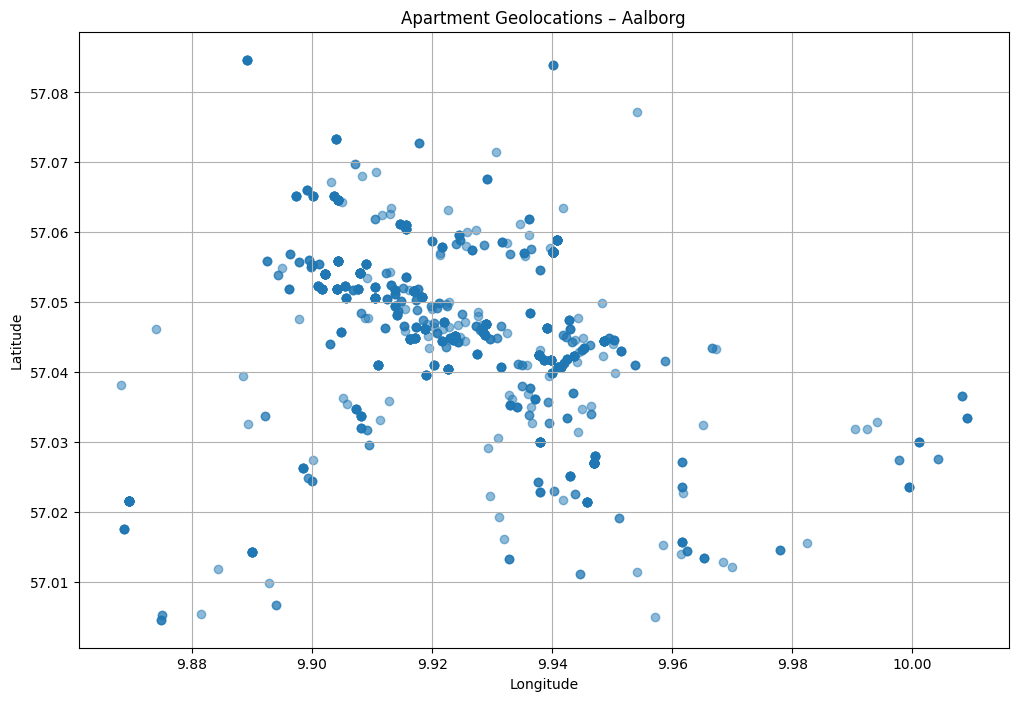

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df["lon"], df["lat"], alpha=0.5)
plt.title("Apartment Geolocations – Aalborg")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


Clustering by location for effient amenity fetching

In [ ]:
# 1. Micro-zone clustering
from sklearn.cluster import DBSCAN
import numpy as np

coords = df.dropna(subset=["lat","lon"])[["lat","lon"]].to_numpy()
# Use eps ~ 0.005 ≈ ~500 m (depends on lat)
db = DBSCAN(eps=0.005, min_samples=3).fit(coords)
df_nonnull = df.dropna(subset=["lat","lon"]).copy()
df_nonnull["micro_zone_id"] = db.labels_

df = df.merge(df_nonnull[["url","micro_zone_id"]], on="url", how="left")

# 2. Compute zone centroids
zone_centroids = df_nonnull.groupby("micro_zone_id")[["lat","lon"]].mean().reset_index()

In [ ]:
zone_centroids

,micro_zone_id,lat,lon
0,-1,57.027647,9.929199
1,0,57.045006,9.924380
2,1,57.066474,9.902686
3,2,57.058182,9.934007
4,3,57.041020,9.910927
5,4,57.020739,9.869424
6,5,57.033402,9.908234
7,6,57.014799,9.979094
8,7,57.025686,9.899108
9,8,57.024924,9.961638


Minor tweaks to avoid Overpass hitting us with a “**thou shalt not spam my servers**” message:

✅ Increase timeout

✅ Slight delay between requests

✅ Cache repeated coordinates

✅ Add tqdm to see progress

✅ Use sample first (then scale up later for full dataset you prepare before lecture)

In [ ]:
from tqdm import tqdm
import requests
import pandas as pd
from functools import lru_cache

# Amenity types to search
amenity_types = ["restaurant", "cafe", "bar", "fast_food", "supermarket", "bus_station", "school"]

@lru_cache(maxsize=None)
def get_nearby_places(lat, lon, radius_m, amenity_type):
    overpass_url = "https://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    node(around:{radius_m},{lat},{lon})["amenity"="{amenity_type}"];
    out;
    """
    try:
        resp = requests.post(overpass_url, data={'data': query}, timeout=10)
        data = resp.json()
    except:
        return pd.DataFrame()

    places = []
    for el in data.get("elements", []):
        if "lat" in el and "lon" in el:
            places.append({
                "amenity": amenity_type,
                "lat": el["lat"],
                "lon": el["lon"],
                "name": el.get("tags", {}).get("name"),
                "radius_m": radius_m
            })
    return pd.DataFrame(places)

In [ ]:
from tqdm import tqdm
import pandas as pd

radii = [500, 1000, 2000]  # meters
zone_amenities = []

# Progress bar around zone_centroids (outer level)
for _, z in tqdm(zone_centroids.iterrows(),
                 total=len(zone_centroids),
                 desc="Processing zone centroids"):

    for r in radii:
        for atype in amenity_types:

            adf = get_nearby_places(z["lat"], z["lon"], r, atype)
            if not adf.empty:
                adf["zone_id"] = z["micro_zone_id"]
                adf["radius_m"] = r
                adf["amenity_type"] = atype
                zone_amenities.append(adf)

        # mini-status every radius step
        print(f"Zone {z['micro_zone_id']} / Radius {r} → Total entries: {sum(len(x) for x in zone_amenities)}")

# ✅ Combine
if zone_amenities:
    zone_amenities_df = pd.concat(zone_amenities, ignore_index=True)
else:
    zone_amenities_df = pd.DataFrame()

print("\n✅ Amenity rows collected:", len(zone_amenities_df))

# ✅ Pivot: zone × radius × amenity → feature table
if not zone_amenities_df.empty:
    zone_features_df = (
        zone_amenities_df
        .groupby(["zone_id", "radius_m", "amenity_type"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
else:
    zone_features_df = pd.DataFrame()

print("✅ Feature table shape:", zone_features_df.shape)

# ✅ Attach back to listings
df = df.merge(zone_features_df,
              left_on="micro_zone_id",
              right_on="zone_id",
              how="left")

df.drop(columns=["zone_id"], inplace=True)

print("\n✅ Join back → df now has shape:", df.shape)


Processing zone centroids:   0%|          | 0/24 [00:00<?, ?it/s]

Zone -1.0 / Radius 500 → Total entries: 4
Zone -1.0 / Radius 1000 → Total entries: 9


Processing zone centroids:   4%|▍         | 1/24 [01:00<23:14, 60.64s/it]

Zone -1.0 / Radius 2000 → Total entries: 22
Zone 0.0 / Radius 500 → Total entries: 103
Zone 0.0 / Radius 1000 → Total entries: 198


Processing zone centroids:   8%|▊         | 2/24 [02:09<24:00, 65.47s/it]

Zone 0.0 / Radius 2000 → Total entries: 406
Zone 1.0 / Radius 500 → Total entries: 411
Zone 1.0 / Radius 1000 → Total entries: 411


Processing zone centroids:  12%|█▎        | 3/24 [03:20<23:47, 67.98s/it]

Zone 1.0 / Radius 2000 → Total entries: 428
Zone 2.0 / Radius 500 → Total entries: 430
Zone 2.0 / Radius 1000 → Total entries: 433


Processing zone centroids:  17%|█▋        | 4/24 [04:53<25:54, 77.75s/it]

Zone 2.0 / Radius 2000 → Total entries: 732
Zone 3.0 / Radius 500 → Total entries: 733
Zone 3.0 / Radius 1000 → Total entries: 755


Processing zone centroids:  21%|██        | 5/24 [06:17<25:23, 80.18s/it]

Zone 3.0 / Radius 2000 → Total entries: 939
Zone 4.0 / Radius 500 → Total entries: 939
Zone 4.0 / Radius 1000 → Total entries: 939


Processing zone centroids:  25%|██▌       | 6/24 [07:19<22:10, 73.91s/it]

Zone 4.0 / Radius 2000 → Total entries: 962
Zone 5.0 / Radius 500 → Total entries: 967
Zone 5.0 / Radius 1000 → Total entries: 967


Processing zone centroids:  29%|██▉       | 7/24 [08:58<23:18, 82.26s/it]

Zone 5.0 / Radius 2000 → Total entries: 1082
Zone 6.0 / Radius 500 → Total entries: 1082
Zone 6.0 / Radius 1000 → Total entries: 1087


Processing zone centroids:  33%|███▎      | 8/24 [09:56<19:52, 74.53s/it]

Zone 6.0 / Radius 2000 → Total entries: 1115
Zone 7.0 / Radius 500 → Total entries: 1117
Zone 7.0 / Radius 1000 → Total entries: 1119


Processing zone centroids:  38%|███▊      | 9/24 [10:52<17:10, 68.73s/it]

Zone 7.0 / Radius 2000 → Total entries: 1138
Zone 8.0 / Radius 500 → Total entries: 1141
Zone 8.0 / Radius 1000 → Total entries: 1145


Processing zone centroids:  42%|████▏     | 10/24 [12:04<16:13, 69.53s/it]

Zone 8.0 / Radius 2000 → Total entries: 1180
Zone 9.0 / Radius 500 → Total entries: 1189
Zone 9.0 / Radius 1000 → Total entries: 1199


Processing zone centroids:  46%|████▌     | 11/24 [13:14<15:06, 69.74s/it]

Zone 9.0 / Radius 2000 → Total entries: 1215
Zone 10.0 / Radius 500 → Total entries: 1218
Zone 10.0 / Radius 1000 → Total entries: 1227


Processing zone centroids:  50%|█████     | 12/24 [14:06<12:51, 64.30s/it]

Zone 10.0 / Radius 2000 → Total entries: 1249
Zone 11.0 / Radius 500 → Total entries: 1265
Zone 11.0 / Radius 1000 → Total entries: 1286


Processing zone centroids:  54%|█████▍    | 13/24 [15:01<11:16, 61.49s/it]

Zone 11.0 / Radius 2000 → Total entries: 1309
Zone 12.0 / Radius 500 → Total entries: 1309


In [ ]:
df.head(5)

In [2]:
import pandas as pd

In [3]:
#df.to_csv("apartments_amenities.csv", index=False)
df = pd.read_csv("apartments_clean_flattened.csv")

In [5]:
df.columns.to_list()

['url',
 'title',
 'address',
 'description',
 'images',
 'scraped_at',
 'type',
 'size_m2_raw',
 'rooms',
 'floor',
 'furnished',
 'shared_friendly',
 'pets_allowed',
 'elevator',
 'senior_friendly',
 'students_only',
 'balcony',
 'parking',
 'dishwasher',
 'washing_machine',
 'charging_station',
 'dryer',
 'lease_period',
 'available_from_raw',
 'rent_raw',
 'Aconto',
 'Depositum',
 'Forudbetalt husleje',
 'move_in_price_raw',
 'deposit_raw',
 'rent_dkk',
 'move_in_price',
 'deposit_dkk',
 'size_m2',
 'available_from',
 'rent_per_m2',
 'lat',
 'lon',
 'micro_zone_id',
 'bar_1000m',
 'bar_2000m',
 'bar_500m',
 'cafe_1000m',
 'cafe_2000m',
 'cafe_500m',
 'fast_food_1000m',
 'fast_food_2000m',
 'fast_food_500m',
 'restaurant_1000m',
 'restaurant_2000m',
 'restaurant_500m',
 'school_1000m',
 'school_2000m',
 'school_500m']

In [9]:
df.head(5)

,url,title,address,description,images,scraped_at,type,size_m2_raw,rooms,floor,...,cafe_500m,fast_food_1000m,fast_food_2000m,fast_food_500m,restaurant_1000m,restaurant_2000m,restaurant_500m,school_1000m,school_2000m,school_500m
0,https://www.boligportal.dk/lejligheder/aalborg...,Lille 2 vær. Istedgade,"Istedgade, 9000 Aalborg, Aalborg - Stuen",Hyggelig lille renoveret 2 værelses lejlighed ...,['https://image-lambda.boligportal.dk/b08dd0d5...,2025-11-02T10:16:37.163240,Lejlighed,44 m²,2.0,Stuen,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
1,https://www.boligportal.dk/lejligheder/aalborg...,Central stor 2V m. udsigt til Skovdalen og Aal...,"Prinsensgade, 9000 Aalborg, Aalborg - 4. sal",Attraktiv og istandsat 2-værelses lejlighed me...,['https://image-lambda.boligportal.dk/e4cefa61...,2025-11-02T10:16:43.943020,Lejlighed,68 m²,2.0,4.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
2,https://www.boligportal.dk/lejligheder/aalborg...,Totalrenoveret lækker 3 vær. m. altan i vestbyen,"Ryesgade, 9000 Aalborg, Aalborg - 1. sal",✨ Helt nyrenoveret 2-værelses lejlighed i Ryes...,['https://image-lambda.boligportal.dk/3a925755...,2025-11-02T10:16:48.973611,Lejlighed,68 m²,3.0,1.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
3,https://www.boligportal.dk/lejligheder/aalborg...,Moderniseret lejlighed i centrum af Aalborg,"Vesterbro, 9000 Aalborg, Aalborg - 4. sal",Velindrettet 2-værelses lejlighed beliggende p...,['https://image-lambda.boligportal.dk/c487e74d...,2025-11-02T10:16:53.815168,Lejlighed,73 m²,2.0,4.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
4,https://www.boligportal.dk/lejligheder/aalborg...,Toprenoveret hyggelig 2-vær. i hjertet af Aalborg,"Søndergade, 9000 Aalborg, Aalborg - 2. sal",**Indbydende Lejlighed på Søndergade – Perfekt...,['https://image-lambda.boligportal.dk/4c7c6b09...,2025-11-02T10:16:59.605824,Lejlighed,56 m²,2.0,2.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0


In [7]:
import pandas as pd
import re

# --- 1. Drop listings with invalid zone ---
mask_valid = df["micro_zone_id"].notna() & (df["micro_zone_id"] != -1)
df = df[mask_valid].reset_index(drop=True)
print("After drop, listings count:", df.shape[0])

# --- 2. Flatten radius rows into wide format ---
# a) Melt current rows (assuming each row still has radius_m + amenity counts)
melt_cols = ["url", "micro_zone_id", "radius_m", "bar", "cafe", "fast_food", "restaurant", "school"]
long = df[melt_cols].melt(
    id_vars=["url", "micro_zone_id", "radius_m"],
    value_vars=["bar", "cafe", "fast_food", "restaurant", "school"],
    var_name="amenity",
    value_name="count"
)

# b) Clean radius_m (ensure integer)
long["radius_m"] = pd.to_numeric(long["radius_m"], errors="coerce").fillna(0).astype(int)

# c) Create amenity_radius column
long["amenity_radius"] = long["amenity"] + "_" + long["radius_m"].astype(str) + "m"

# d) Pivot to wide
wide = (
    long.pivot_table(
        index=["url", "micro_zone_id"],
        columns="amenity_radius",
        values="count",
        aggfunc="sum",
        fill_value=0
    )
    .reset_index()
)

# e) Merge back with main listing data excluding old radius/amenities
keep_cols = [c for c in df.columns if c not in ["radius_m", "bar", "cafe", "fast_food", "restaurant", "school"]]
df_base = df[keep_cols].drop_duplicates(subset=["url"])

df_clean = df_base.merge(wide, on=["url", "micro_zone_id"], how="left")
print("After flattening, final shape:", df_clean.shape)

df_clean.head(5)

df = df_clean  # update df to use cleaned dataset

# --- 3. Save cleaned dataset ---
df.to_csv("apartments_clean_flattened.csv", index=False)


After drop, listings count: 1309


KeyError: "['radius_m', 'bar', 'cafe', 'fast_food', 'restaurant', 'school'] not in index"

## Recommendation engine
Let's start building our recommendation engine

In [ ]:
df.head(5)

,url,title,address,description,images,scraped_at,type,size_m2_raw,rooms,floor,...,cafe_500m,fast_food_1000m,fast_food_2000m,fast_food_500m,restaurant_1000m,restaurant_2000m,restaurant_500m,school_1000m,school_2000m,school_500m
0,https://www.boligportal.dk/lejligheder/aalborg...,Lille 2 vær. Istedgade,"Istedgade, 9000 Aalborg, Aalborg - Stuen",Hyggelig lille renoveret 2 værelses lejlighed ...,['https://image-lambda.boligportal.dk/b08dd0d5...,2025-11-02T10:16:37.163240,Lejlighed,44 m²,2.0,Stuen,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
1,https://www.boligportal.dk/lejligheder/aalborg...,Central stor 2V m. udsigt til Skovdalen og Aal...,"Prinsensgade, 9000 Aalborg, Aalborg - 4. sal",Attraktiv og istandsat 2-værelses lejlighed me...,['https://image-lambda.boligportal.dk/e4cefa61...,2025-11-02T10:16:43.943020,Lejlighed,68 m²,2.0,4.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
2,https://www.boligportal.dk/lejligheder/aalborg...,Totalrenoveret lækker 3 vær. m. altan i vestbyen,"Ryesgade, 9000 Aalborg, Aalborg - 1. sal",✨ Helt nyrenoveret 2-værelses lejlighed i Ryes...,['https://image-lambda.boligportal.dk/3a925755...,2025-11-02T10:16:48.973611,Lejlighed,68 m²,3.0,1.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
3,https://www.boligportal.dk/lejligheder/aalborg...,Moderniseret lejlighed i centrum af Aalborg,"Vesterbro, 9000 Aalborg, Aalborg - 4. sal",Velindrettet 2-værelses lejlighed beliggende p...,['https://image-lambda.boligportal.dk/c487e74d...,2025-11-02T10:16:53.815168,Lejlighed,73 m²,2.0,4.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0
4,https://www.boligportal.dk/lejligheder/aalborg...,Toprenoveret hyggelig 2-vær. i hjertet af Aalborg,"Søndergade, 9000 Aalborg, Aalborg - 2. sal",**Indbydende Lejlighed på Søndergade – Perfekt...,['https://image-lambda.boligportal.dk/4c7c6b09...,2025-11-02T10:16:59.605824,Lejlighed,56 m²,2.0,2.,...,24.0,94.0,139.0,38.0,63.0,69.0,19.0,0.0,0.0,0.0


In [ ]:
zone_features_df.head()


amenity_type,zone_id,radius_m,bar,cafe,fast_food,restaurant,school
0,-1.0,500,0,0,2,2,0
1,-1.0,1000,0,0,5,2,0
2,-1.0,2000,9,8,31,0,0
3,0.0,500,0,24,38,19,0
4,0.0,1000,51,44,94,63,0


We will start with a simple similarity based recommender. It creates a vector for each apartment, and compares it to a vector for user preferences that we form upon the search.

In [ ]:
# 7. Build content-based recommender

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

features = [
    "rent_per_m2",
    "size_m2",
    "pets_allowed",
    "cafe_500m",
    "restaurant_500m",
    "school_500m"
    # add other amenity features if desired
]

# Prepare feature matrix
X = df[features].copy()
X["pets_allowed"] = X["pets_allowed"].fillna(False).astype(int)
X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Example “user preferences” vector
user_profile = {
    "max_rent_per_m2": 100,
    "min_size_m2": 50,
    "pets_allowed": True,
    "desired_cafe_500m": 10,
    "desired_restaurant_500m": 20,
    "desired_school_500m": 1
}
import numpy as np
u = np.array([
    user_profile["max_rent_per_m2"]*-1,      # lower is better → invert sign
    user_profile["min_size_m2"],
    int(user_profile["pets_allowed"]),
    user_profile["desired_cafe_500m"],
    user_profile["desired_restaurant_500m"],
    user_profile["desired_school_500m"]
])
u_scaled = scaler.transform(u.reshape(1,-1))

# Compute similarity
cos_sim = cosine_similarity(u_scaled, X_scaled).flatten()
df["similarity"] = cos_sim

# Get top 5
top5 = df.nlargest(5, "similarity")[["url","title","address","similarity"]]
print("Top 5 matches based on your preferences:")
print(top5.to_string(index=False))


Top 5 matches based on your preferences:
                                                                   url                                                                 title                                    address  similarity
 https://www.boligportal.dk/lejligheder/aalborg/62m2-2-vaer-id-5552067                                                2 værelset studiebolig   Sonjavej, 9000 Aalborg, Aalborg - 1. sal    0.826467
 https://www.boligportal.dk/lejligheder/aalborg/50m2-2-vaer-id-5565335                          2 værelses lejlighed på Golfbakken i Aalborg Golfbakken, 9000 Aalborg, Aalborg - 1. sal    0.805249
 https://www.boligportal.dk/lejligheder/aalborg/95m2-3-vaer-id-5563375             Lys 3-værelses på 95 m² med altan, elevator & parkering 🌿  Golfhaven, 9000 Aalborg, Aalborg - 2. sal    0.779269
 https://www.boligportal.dk/lejligheder/aalborg/95m2-4-vaer-id-5556931 Lækker og lys lejlighed, beliggende i skønne omgivelser med parkering  Golfhaven, 9000 Aalborg, Aalborg 

/tmp/ipython-input-3059904383.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X["pets_allowed"] = X["pets_allowed"].fillna(False).astype(int)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Another method is k-nearest-neighbour recommendation. Here we first do clustering to group the apartments, and then use that to recommend what is most similar

In [ ]:
df[df.school_500m != 0]

,url,title,address,description,images,scraped_at,type,size_m2_raw,rooms,floor,...,cafe_500m,fast_food_1000m,fast_food_2000m,fast_food_500m,restaurant_1000m,restaurant_2000m,restaurant_500m,school_1000m,school_2000m,school_500m
50,https://www.boligportal.dk/lejligheder/aalborg...,4 værelses lejlighed på Sonjavej i Aalborg,"Sonjavej, 9000 Aalborg, Aalborg","I Vejgaard ligger denne afdeling, som består a...",['https://image-lambda.boligportal.dk/f511f738...,2025-11-02T10:21:20.271616,Lejlighed,104 m²,4.0,-,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
316,https://www.boligportal.dk/lejligheder/aalborg...,2 værelset studiebolig,"Sonjavej, 9000 Aalborg, Aalborg - 1. sal",Denne lejlighed kræver at du er studerende ell...,['https://image-lambda.boligportal.dk/cdf72862...,2025-11-02T10:45:19.500206,Lejlighed,62 m²,2.0,1.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
359,https://www.boligportal.dk/lejligheder/aalborg...,2 værelses lejlighed på Golfbakken i Aalborg,"Golfbakken, 9000 Aalborg, Aalborg - 1. sal",Boligen udlejes af en almen boligorganisation....,['https://image-lambda.boligportal.dk/b4612b99...,2025-11-02T10:49:09.209611,Lejlighed,50 m²,2.0,1.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
533,https://www.boligportal.dk/lejligheder/aalborg...,3 værelses lejlighed på Sonjavej i Aalborg,"Sonjavej, 9000 Aalborg, Aalborg - 1. sal","I Vejgaard ligger denne afdeling, som består a...",['https://image-lambda.boligportal.dk/f19800e5...,2025-11-02T11:04:40.813772,Lejlighed,85 m²,3.0,1.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
910,https://www.boligportal.dk/lejligheder/aalborg...,"Lys og moderne 3-værelses på 95 m2 med altan, ...","Golfhaven, 9000 Aalborg, Aalborg - 1. sal",Velkommen til en rummelig og indflytningsklar ...,['https://image-lambda.boligportal.dk/be4687ed...,2025-11-02T11:38:08.157392,Lejlighed,95 m²,3.0,1.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1010,https://www.boligportal.dk/lejligheder/aalborg...,"Lækker og lys lejlighed, beliggende i skønne o...","Golfhaven, 9000 Aalborg, Aalborg - 1. sal",I rolige og attraktive omgivelser udlejes denn...,['https://image-lambda.boligportal.dk/7e94c222...,2025-11-02T11:47:14.052361,Lejlighed,95 m²,4.0,1.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1069,https://www.boligportal.dk/lejligheder/aalborg...,"Lys 3-værelses på 95 m² med altan, elevator & ...","Golfhaven, 9000 Aalborg, Aalborg - 2. sal",Drømmer du om en moderne og rummelig lejlighed...,['https://image-lambda.boligportal.dk/61c8abc1...,2025-11-02T11:52:41.310915,Lejlighed,95 m²,3.0,2.,...,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Feature selection for similarity ---
features = [
    "rent_per_m2", "size_m2",
    "cafe_500m", "restaurant_500m", "bar_500m",
    "school_1000m", "restaurant_1000m", "cafe_1000m"
]

# Filter only rows with all needed values
df_model = df.dropna(subset=features).reset_index(drop=True)

# Boolean encoding robust to None values
df_model["pets_allowed"] = df_model["pets_allowed"].map({True: 1, False: 0, None: 0})
X["pets_allowed"] = df_model["pets_allowed"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(X_scaled)

def recommend_similar(listing_index, n_results=5):
    vec = X_scaled[listing_index].reshape(1, -1)
    distances, indices = knn.kneighbors(vec, n_results+1)

    # skip first result (itself)
    rec_idx = indices[0][1:]
    sims = 1 - distances[0][1:]

    results = df_model.loc[rec_idx, ["url", "title", "address"]].copy()
    results["similarity"] = sims
    return results


In [ ]:
recommend_similar(0)

,url,title,address,similarity
1207,https://www.boligportal.dk/lejligheder/aalborg...,SKØN CENTRAL LEJLIGHED MED HEMS OG SYDVENDT ALTAN,"Hasserisgade, 9000 Aalborg, Aalborg - 1. sal",0.999294
662,https://www.boligportal.dk/lejligheder/aalborg...,"Lejligheden har nyere køkken, nyere badeværels...","Dannebrogsgade, 9000 Aalborg, Aalborg - 3. sal",0.998688
226,https://www.boligportal.dk/lejligheder/aalborg...,Lys pæn 2 vær. lejlighed i 9000 Aalborg - Vejg...,"Hadsundvej, 9000 Aalborg, Aalborg - 1. sal",0.998394
973,https://www.boligportal.dk/lejligheder/aalborg...,Charmerende 2-værelses lejlighed i Aalborg vestby,"Valdemarsgade, 9000 Aalborg, Aalborg - 1. sal",0.996873
79,https://www.boligportal.dk/lejligheder/aalborg...,Toprenoveret 1-vær. m/åbent køkken-alrum,"Prinsensgade, 9000 Aalborg, Aalborg - 2. sal",0.996850


This is all well and good, but it doesn't really allow for softer preferences (ie it could be an absolute demand that I can bring my dog, and other amenities are slightly less important). We need to enable the system to capture those types of user preference nuances, and we can do this by creating a weight vector *w*

We can then multiply this *w* vector into our user preferences vector, and then use that *weighted user* vector *w_u* to determine recommendations.

```
w_rent = -0.4  
w_cafes500m = +0.3  
w_pets_allowed = +0.2  
w_bar500m = +0.1

`score = w_rent*rent_per_m2 + w_cafes500m*cafe_500m + w_pets_allowed*(1 if pets_allowed else 0) + w_bar500m*bar_500m`
```


In [ ]:
# 🔧 Adjustable weights section
print("Enter your preference weights (sum doesn’t have to be 1)")

rent_weight      = float(input("Weight for rent_per_m2 (negative means cheaper is better): "))
size_weight      = float(input("Weight for size_m2 (bigger is better): "))
pet_weight       = float(input("Weight for pets_allowed (1 if yes else 0): "))
cafe500_weight   = float(input("Weight for cafe_500m: "))
bar500_weight    = float(input("Weight for bar_500m: "))

# Ensure numeric & no missing values
df["pets_allowed"] = df["pets_allowed"].fillna(False).astype(int)
df["rent_per_m2"] = pd.to_numeric(df["rent_per_m2"], errors="coerce")
df["size_m2"] = pd.to_numeric(df["size_m2"], errors="coerce")

# Compute weighted score
df["custom_score"] = (
    df["rent_per_m2"].fillna(df["rent_per_m2"].median()) * rent_weight +
    df["size_m2"].fillna(df["size_m2"].median()) * size_weight +
    df["pets_allowed"] * pet_weight +
    df.get("cafe_500m", pd.Series(0, index=df.index)) * cafe500_weight +
    df.get("bar_500m", pd.Series(0, index=df.index)) * bar500_weight
)

# Convert to numeric so nlargest works
df["custom_score"] = pd.to_numeric(df["custom_score"], errors="coerce")

# Show top matches by custom_score
top_custom = df.nlargest(5, "custom_score")[["url","title","address","custom_score"]]
print("\nTop 5 based on your custom weights:")
print(top_custom.to_string(index=False))


Enter your preference weights (sum doesn’t have to be 1)
Weight for rent_per_m2 (negative means cheaper is better): 0
Weight for size_m2 (bigger is better): 0
Weight for pets_allowed (1 if yes else 0): 0
Weight for cafe_500m: 0
Weight for bar_500m: 0

Top 5 based on your custom weights:
                                                                  url                                                    title                                      address  custom_score
https://www.boligportal.dk/lejligheder/aalborg/44m2-2-vaer-id-4207581                                   Lille 2 vær. Istedgade     Istedgade, 9000 Aalborg, Aalborg - Stuen           0.0
https://www.boligportal.dk/lejligheder/aalborg/68m2-2-vaer-id-3732010 Central stor 2V m. udsigt til Skovdalen og Aalborgtårnet Prinsensgade, 9000 Aalborg, Aalborg - 4. sal           0.0
https://www.boligportal.dk/lejligheder/aalborg/68m2-3-vaer-id-4241830         Totalrenoveret lækker 3 vær. m. altan i vestbyen     Ryesgade, 9000 Aalborg,

/tmp/ipython-input-207208697.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pets_allowed"] = df["pets_allowed"].fillna(False).astype(int)


# Mapping our recommendations (UX)

In [ ]:
import folium
from folium import plugins

# Parameters
top_n = 10
zoom_start = 14
map_tiles = "cartodb positron"

# Select top listings by custom_score
top_listings = df.nlargest(top_n, "custom_score").reset_index(drop=True)

# Compute map center: mean lat/lon of top listings
center_lat = top_listings["lat"].mean()
center_lon = top_listings["lon"].mean()

# Create map
m = folium.Map(location=[center_lat, center_lon],
               tiles=map_tiles,
               zoom_start=zoom_start)

# Add all listings as light grey small markers (optional context)
for _, row in df.dropna(subset=["lat","lon"]).iterrows():
    folium.CircleMarker(
        [row["lat"], row["lon"]],
        radius=3,
        color="#AAAAAA",
        fill=True,
        fill_opacity=0.3,
        tooltip=row["title"],
    ).add_to(m)

# Add top listings in stronger color
for idx, row in top_listings.iterrows():
    folium.Marker(
        [row["lat"], row["lon"]],
        tooltip=f"{row['title']} (Score: {row['custom_score']:.2f})",
        popup=(
            f"<strong>{row['title']}</strong><br>"
            f"{row['address']}<br>"
            f"Rent per m²: {row['rent_per_m2']:.1f} kr<br>"
            f"Size: {row['size_m2']} m²<br>"
            f"<a href='{row['url']}' target='_blank'>Link → listing</a>"
        ),
        icon=folium.Icon(color="blue", icon="home", prefix="fa")
    ).add_to(m)

# Display map
m
